In [ ]:
# Nate Brunacini, nbrunaci@u.rochester.edu
# Supervisor: Kelly A. Douglass
# This file includes methods used to calculate the metallicity value at each spaxel in a MaNGA galaxy using methods (N2, 
# O3N2, and N2O2) described in the 2016 paper by Brown et al. Commented out is code to recreate specified figures from 
# that paper.

In [1]:
# Import packages

import marvin
from marvin.tools.maps import Maps
from marvin.tools import Image

import numpy as np
import numpy.ma as ma
from numpy import log10, pi

import matplotlib.pyplot as plt

from astropy.io import fits
import astropy.constants as const

/home/nbrunaci/.local/lib/python3.9/site-packages/marvin/core/exceptions.py:50: UserWarning: cannot initiate Sentry error reporting: [Errno 6] No such device or address.
  warnings.warn('cannot initiate Sentry error reporting: {0}.'.format(str(ee)),
[INFO]: No release version set. Setting default to DR15
[WARNING]: path /home/nbrunaci/sas/mangawork/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /home/nbrunaci/sas/mangawork/manga/spectro/analysis/v2_4_3/2.2.1/dapall-v2_4_3-2.2.1.fits cannot be found. Setting dapall to None. (MarvinUserWarning)


In [3]:
# Takes in plate and IFU numbers of a galaxy, returns nested dictionary of each relevent emission line's flux and inverse variance in masked arrays
# Called by addDiagnostics function
def getDataMaps(plateifu):
    maps = Maps(plateifu)
    
    # Obtaining redshift data from drpall fits file
    with fits.open('drpall-v2_4_3.fits', memmap=True) as drpall:
        tbdata = drpall[1].data
        ind = np.where(tbdata['plateifu'] == plateifu)
        redshift = tbdata['nsa_z'][ind][0]# This [0] is here because each z value seems to be in its own array for some reason
    
    # Observed emission lines
    HaF_map = maps["emline_gflux_ha_6564"]
    HbF_map = maps["emline_gflux_hb_4862"]
    OII_map = maps["emline_gflux_oii_3727"]
    OIII_map = maps["emline_gflux_oiii_5008"]
    NII_map = maps["emline_gflux_nii_6585"]
    
    # Flux for observed lines (masked arrays)
    HaF_flux_m = HaF_map.masked
    HbF_flux_m = HbF_map.masked
    OII_flux_m = OII_map.masked
    OIII_flux_m = OIII_map.masked
    NII_flux_m = NII_map.masked
    
    # Inverse variance for observed lines (masked arrays)
    HaF_ivar_m = ma.array(HaF_map.ivar,mask=HaF_map.mask)
    HbF_ivar_m = ma.array(HbF_map.ivar,mask=HbF_map.mask)
    OII_ivar_m = ma.array(OII_map.ivar,mask=OII_map.mask)
    OIII_ivar_m = ma.array(OIII_map.ivar,mask=OIII_map.mask)
    NII_ivar_m = ma.array(NII_map.ivar,mask=NII_map.mask)
    
    return{
        'z': redshift,
        'HaF': {'flux': HaF_flux_m, 'ivar': HaF_ivar_m},
        'HbF': {'flux': HbF_flux_m, 'ivar': HbF_ivar_m},
        'OII': {'flux': OII_flux_m, 'ivar': OII_ivar_m},
        'OIII': {'flux': OIII_flux_m, 'ivar': OIII_ivar_m},
        'NII': {'flux': NII_flux_m, 'ivar': NII_ivar_m}
    }

In [4]:
# Takes in output from getDataMaps function, returns dictionary of inverse variance arrays for calculated abundance diagnostics
# Called by addDiagnostics function
def getDiagnosticIvars(observed):
    a = observed['HaF']['flux']
    b = observed['HbF']['flux']
    oii = observed['OII']['flux']
    oiii = observed['OIII']['flux']
    nii = observed['NII']['flux']
    ia = observed['HaF']['ivar']
    ib = observed['HbF']['ivar']
    ioii = observed['OII']['ivar']
    ioiii = observed['OIII']['ivar']
    inii = observed['NII']['ivar']
    
    # N2 ivar calculations:
    # N2 = f(n,a) where n=NII, a=HaF
    # f = n/a
    # ivar_f = 1.0 / ( (df/dn)**2/ivar_n + (df/da)**2/ivar_a ) where d means partial derivative
    # Evaluated: ivar_f = 1.0 / ( 1.0/(a**2*ivar_n) + n**2/(a**4*ivar_a) )
    N2_ivar_m = 1.0 / (1.0/(a**2*inii) + nii**2/(a**4*ia))
    
#     # O3N2 ivar calculations (old):
#     # O3N2 = f(o,b,n,a) where o=OIII, b=HbF, n=NII, a=HaF
#     # f = o/b/n/a = o/(bna)
#     # ivar_f = 1.0 / ( (df/do)**2/ivar_o + (df/db)**2/ivar_b + (df/dn)**2/ivar_n + (df/da)**2/ivar_a ) where d means partial derivative
#     # Evaluated: ivar_f = 1.0 / ( 1.0/((b*n*a)**2*ivar_o) + (o/(b**2*n*a))**2/ivar_b + (o/(b*n**2*a))**2/ivar_n + (o/(b*n*a**2))**2/ivar_a )
#     O3N2_ivar_m = 1.0 / (1.0/((b*nii*a)**2*ioiii) + (oiii/(b**2*nii*a))**2/ib + (oiii/(b*nii**2*a))**2/inii + (oiii/(b*nii*a**2))**2/ia)
    
    # O3N2 ivar calculations:
    # O3N2 = f(o,b,n,a) where o=OIII, b=HbF, n=NII, a=HaF
    # f = o/b/(n/a) = oa/bn
    # ivar_f = 1.0 / ( (df/do)**2/ivar_o + (df/db)**2/ivar_b + (df/dn)**2/ivar_n + (df/da)**2/ivar_a ) where d means partial derivative
    # Evaluated: ivar_f = 1.0 / ( (a/(b*n))**2/ivar_o + (-o*a/(b**2*n))**2/ivar_b + (-o*a/(b*n**2))**2/ivar_n + (o*a/(b*n))**2/ivar_a )
    O3N2_ivar_m = 1.0 / ( (a/(b*nii))**2/ioiii + (-oiii*a/(b**2*nii))**2/ib + (-oiii*a/(b*nii**2))**2/inii + (oiii*a/(b*nii))**2/ia )
    
    # N2O2 ivar calculations:
    # N2O2 = f(n,o) where n=NII, o=OII (Note: Not the same o as used in above O3N2 calculations)
    # f = n/o
    # ivar_f = 1.0 / ( (df/dn)**2/ivar_n + (df/do)**2/ivar_o ) where d means partial derivative
    # Evaluated: ivar_f = 1.0 / ( 1.0/(o**2*ivar_n) + n**2/(o**4*ivar_o) )
    N2O2_ivar_m = 1.0 / (1.0/(oii**2*inii)+nii**2/(oii**4*ioii))
    
    return {
        'N2': N2_ivar_m,
        'O3N2': O3N2_ivar_m,
        'N2O2': N2O2_ivar_m
    }

In [5]:
# Takes in plate and IFU numbers of a galaxy, returns dictionary of observed lines from getDataMaps function plus calculated abundance diagnostics
def addDiagnostics(plateifu):
    observed = getDataMaps(plateifu)
    
    HaF_flux_m = observed['HaF']['flux']
    HbF_flux_m = observed['HbF']['flux']
    OII_flux_m = observed['OII']['flux']
    OIII_flux_m = observed['OIII']['flux']
    NII_flux_m = observed['NII']['flux']
    
    # Flux for calculated abundance diagnostics (masked)
    N2_flux_m = NII_flux_m / HaF_flux_m
    O3N2_flux_m = OIII_flux_m / HbF_flux_m / N2_flux_m
    N2O2_flux_m = NII_flux_m / OII_flux_m
    
    # Inverse variance for calculated abuance diagnostics (masked)
    dIvars = getDiagnosticIvars(observed)
    
    diagnostics = {
        'N2': {'flux': N2_flux_m, 'ivar': dIvars['N2']},
        'O3N2': {'flux': O3N2_flux_m, 'ivar': dIvars['O3N2']},
        'N2O2': {'flux': N2O2_flux_m, 'ivar': dIvars['N2O2']}
    }
    return observed | diagnostics

In [6]:
# Takes in plate and IFU numbers of a galaxy, returns mass map; note that the values in the mass map are actually the log10 of the mass density
def getMassMap(plateifu):
    plate = plateifu.split('-')[0]
    path = '/scratch/kdougla7/data/SDSS/dr15/manga/spectro/pipe3d/v2_4_3/2.4.3/'+plate+'/manga-'+plateifu+'.Pipe3D.cube.fits.gz'
    with fits.open(path, memmap=True) as file:
        massMap = file[1].data[19]# This should access the log10 of stellar mass density per pixel with dust correction
    return massMap

In [7]:
# Takes in output from addDiagnostics function, returns dictionary of inverse variance arrays for each metallicity method
# Called by findMetallicities function
def getMetallicityIvars(dataMaps):
    # Constants (The names of these variables are of no significance)
    #D = 0.58#
    #E = 0.19#
    E2 = 0.12
    B2 = 0.83
    D2 = 0.20
    M = 1.0/2.5
    N = 5.91
    W = 0.32
    X = 0.18
    P = 0.54
    S = 0.36
    ln10 = ma.log(10)
    C2 = 5.91*M
    
    # Flux maps
    a = dataMaps['HaF']['flux']
    b = dataMaps['HbF']['flux']
    nii = dataMaps['NII']['flux']
    oii = dataMaps['OII']['flux']
    oiii = dataMaps['OIII']['flux']
    
    # Inverse variance maps
    ia = dataMaps['HaF']['ivar']
    ib = dataMaps['HbF']['ivar']
    inii = dataMaps['NII']['ivar']
    ioii = dataMaps['OII']['ivar']
    ioiii = dataMaps['OIII']['ivar']
    
    # N2 metallicity ivar calculations:
    # N2_metallicity = f(n,a,b) where n=NII, a=HaF, b=HbF
    # f = 9.25 + B2*log10(n/a) + E2*(log10(n/a))**2 - D2*log10(C1*(a/b)^C2*a) + C9 where C1, C2, and C9 are constants
    # This can be condensed to f = log10((n/a)^B2*(C1*(a/b)^C2*a)^-D2) + C10 where C10=9.25+C9
    dfdn_N2 = (2*E2*ma.log(nii/a)+B2*ln10)/(nii*(ln10)**2)
    dfda_N2 = -(2*E2*ma.log(nii/a)+D2*ln10*(C2+1)+B2*ln10)/(a*(ln10)**2)
    dfdb_N2 = C2*D2/(b*ln10)
    N2_metallicity_ivar = 1.0 / ( (dfdn_N2)**2/inii + (dfda_N2)**2/ia + (dfdb_N2)**2/ib )
    
    # O3N2 metallicity ivar calculations:
    # O3N2_metallicity = f(o,b,n,a) where o=OIII, b=HbF, n=NII, a=HaF
    # f = 8.98 - W*log10(o/(b*n*a)) - X*log10(C1*(a/b)**C2*a) + C5 where C5 is a constant
    # This can be condensed to f = log10((o/(b*n*a))**-W*(C1*(a/b)**C2*a)^-X) + C6 where C6=8.98+C5
    dfdo_O3N2 = -W/(oiii*ln10)
    dfdb_O3N2 = (W+C2*X)/(b*ln10)
    dfdn_O3N2 = W/(nii*ln10)
    dfda_O3N2 = -(X*(C2+1)+W)/(a*ln10)#-(X*(C2+1)-W)/(a*ln10) was formerly used
    O3N2_metallicity_ivar = 1.0 / ( (dfdo_O3N2)**2/ioiii + (dfdb_O3N2)**2/ib + (dfdn_O3N2)**2/inii + (dfda_O3N2)**2/ia )
    
    # N2O2 metallicity ivar calculations:
    # N2O2_metallicity = f(a,b,n,o) where a=HaF, b=HbF, n=NII, o=OII (Note: Not the same o as used in above O3N2 calculations)
    # f = 9.20 - P*log10(n/o) - S*log10(C1*(a/b)**C2*a) + C7 where C7 is a constant
    # This can be condensed to f = log10((n/o)**P*(C1*(a/b)**C2*a)^-S) + C8 where C8=9.20+C7
    dfdn_N2O2 = P/(nii*ln10)
    dfdo_N2O2 = -P/(oii*ln10)
    dfda_N2O2 = -S*(C2+1)/(a*ln10)
    dfdb_N2O2 = S*C2/(b*ln10)
    N2O2_metallicity_ivar = 1.0 / ( (dfdn_N2O2)**2/inii + (dfdo_N2O2)**2/ioii + (dfda_N2O2)**2/ia + (dfdb_N2O2)**2/ib )
    
    return {
        'N2': N2_metallicity_ivar,
        'O3N2': O3N2_metallicity_ivar,
        'N2O2': N2O2_metallicity_ivar
    }

In [8]:
# Takes in output from addDiagnostics and getMassMap functions, calculates and returns metallicities calculated using equations from Brown et al. 2016 and their inverse variances
# dataMaps must be a dictionary of the masked flux and ivar of each emission line, as is output by addDiagnostics
# massMap must be a map the log10 of stellar mass values such as that returned by getMassMap
# logN2 is log(N2) values with default None in case log(N2) needs to be entered manually
# logO3N2 is log(O3N2) values with default None in case log(O3N2) needs to be entered manually
# logN2O2 is log(N2O2) values with default None in case log(N2O2) needs to be entered manually
# delt is deltaLogSSFR with default None in case deltaLogSSFR needs to be entered manually
def findMetallicities_Brown(dataMaps,massMap,logN2=None,logO3N2=None,logN2O2=None,delt=None):
    
    z = dataMaps['z']
    c = const.c.value/1000# Speed of light (km/s)
    h = 1# Current Hubble constant value (unitless)
    H0 = 100*h# Hubble constant (km/s/Mpc)
    logmass = massMap# Map of the log10 of stellar mass density per pixel with dust correction; units are log(M_solar/spax**2)

    dl = z*c/H0*3.086E24# Distance luminosity converted from Mpc/h to cm/h
    AHa_map = 5.91 * ma.log10(dataMaps['HaF']['flux'] / dataMaps['HbF']['flux']) - 2.70# Moorman et al 2016 Eq 8; unitless
    fHa_map = dataMaps['HaF']['flux'] * 1E-17 * ( 10 ** ( AHa_map / 2.5) )# Implied in Moorman; units are erg/(cm**2*s)
    LHa_map = 4*pi*dl**2*fHa_map# Moorman; units are erg/s
    SFR_map = 7.9*10**(-41.28)*LHa_map# Moorman Eq 6; units are M_solar/yr; factor here should convert units from erg/s to M_solar/yr according to Kennicutt Eq 2
    logSSFR_map = ma.log10(SFR_map) - logmass# By definition of SSFR; units are log(yr**-1)
    
    # Brown et al Eq 6
    logSSFR_Mstar = 283.728 - 116.265 * logmass + 17.4403 * logmass**2 - 1.17146 * logmass**3 + 0.0296526 * logmass**4# Units are log(M_solar)

    # Brown et al Eq 2
    deltaLogSSFR = logSSFR_map - logSSFR_Mstar# Units are yr**-1
    
    logN2flux = ma.log10(dataMaps['N2']['flux'])
    logO3N2flux = ma.log10(dataMaps['O3N2']['flux'])
    logN2O2flux = ma.log10(dataMaps['N2O2']['flux'])
    
    # Adding in manually entered values, if any
    if logN2 is not None:
        logN2flux = logN2
    if logO3N2 is not None:
        logO3N2flux = logO3N2
    if logN2O2 is not None:
        logN2O2flux = logN2O2
    if delt is not None:
        deltaLogSSFR = delt
    
    # N2 (Brown et al Eq 7), O3N2 (Brown et al Eq 8), and N2O2 (Brown et al Eq 9) metallicities
    #N2_metallicity = 9.12 + 0.58 * logN2flux - 0.19 * deltaLogSSFR# Old N2 method
    N2_metallicity = 9.25 + 0.83 * logN2flux + 0.12 * logN2flux**2 - 0.20 * deltaLogSSFR# Unitless (or dex)
    O3N2_metallicity = 8.98 - 0.32 * logO3N2flux - 0.18 * deltaLogSSFR
    N2O2_metallicity = 9.20 + 0.54 * logN2O2flux - 0.36 * deltaLogSSFR
    
    ivars = getMetallicityIvars(dataMaps)
    
    return{
        'N2':{'metallicity': N2_metallicity, 'ivar': ivars['N2']},
        'O3N2':{'metallicity': O3N2_metallicity, 'ivar': ivars['O3N2']},
        'N2O2':{'metallicity': N2O2_metallicity, 'ivar': ivars['N2O2']},
#         'AHa':AHa_map
#         'fHa':fHa_map,
#         'LHa':LHa_map,
#         'SFR':SFR_map,
#         'logSSFR':logSSFR_map,
#         'logSSFR_Mstar':logSSFR_Mstar,
        'logN2flux':logN2flux,
        'logO3N2flux':logO3N2flux,
        'logN2O2flux':logN2O2flux,
        'deltaLogSSFR':deltaLogSSFR
    }

In [9]:
# # Calling the functions

# plateifu = '9487-12701'#'9871-12702'#'7975-12701'#'8485-1901'
# objmaps = addDiagnostics(plateifu)
# massMap = getMassMap(plateifu)
# results = findMetallicities_Brown(objmaps,massMap)

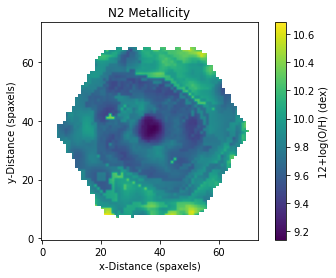

In [10]:
# plt.imshow(results['N2']['metallicity'])
# plt.gca().invert_yaxis()
# plt.locator_params(axis='y', nbins=5)
# plt.title('N2 Metallicity')
# plt.xlabel('x-Distance (spaxels)')
# plt.ylabel('y-Distance (spaxels)')
# plt.colorbar(label='12+log(O/H) (dex)')
# # plt.savefig('PosterMaps/N2metallicity_9487-12701')

Text(0, 0.5, '12+log(O/H)_N2')

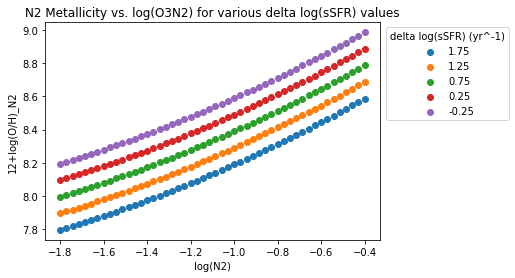

In [16]:
# # Reproducing Figure 4 from Brown et al

# logN2 = np.linspace(-1.8,-0.4)

# results1 = findMetallicities_Brown(objmaps,massMap,logN2=logN2,delt=1.75)
# results2 = findMetallicities_Brown(objmaps,massMap,logN2=logN2,delt=1.25)
# results3 = findMetallicities_Brown(objmaps,massMap,logN2=logN2,delt=0.75)
# results4 = findMetallicities_Brown(objmaps,massMap,logN2=logN2,delt=0.25)
# results5 = findMetallicities_Brown(objmaps,massMap,logN2=logN2,delt=-0.25)

# # plt.figure(figsize=(6,6))

# plt.scatter(results1['logN2flux'],results1['N2']['metallicity'])
# plt.scatter(results2['logN2flux'],results2['N2']['metallicity'])
# plt.scatter(results3['logN2flux'],results3['N2']['metallicity'])
# plt.scatter(results4['logN2flux'],results4['N2']['metallicity'])
# plt.scatter(results5['logN2flux'],results5['N2']['metallicity'])
# plt.legend([1.75,1.25,0.75,0.25,-0.25],title='delta log(sSFR) (yr^-1)',loc='upper right',bbox_to_anchor=(1.4,1))
# plt.title('N2 Metallicity vs. log(O3N2) for various delta log(sSFR) values')
# plt.xlabel('log(N2)')
# plt.ylabel('12+log(O/H)_N2')
# # plt.xlim([-1.8,-0.4])
# # plt.ylim([7.7,9.3])

# # plt.savefig('PosterMaps/BrownFig4Recreation')

Text(0, 0.5, '12+log(O/H)_O3N2')

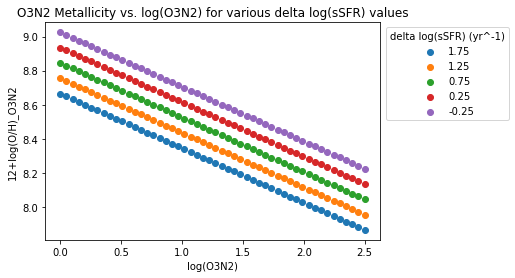

In [17]:
# # Reproducing Figure 5 from Brown et al

# logO3N2 = np.linspace(-0,2.5)

# results1 = findMetallicities_Brown(objmaps,massMap,logO3N2=logO3N2,delt=1.75)
# results2 = findMetallicities_Brown(objmaps,massMap,logO3N2=logO3N2,delt=1.25)
# results3 = findMetallicities_Brown(objmaps,massMap,logO3N2=logO3N2,delt=0.75)
# results4 = findMetallicities_Brown(objmaps,massMap,logO3N2=logO3N2,delt=0.25)
# results5 = findMetallicities_Brown(objmaps,massMap,logO3N2=logO3N2,delt=-0.25)

# # plt.figure(figsize=(6,6))

# plt.scatter(results1['logO3N2flux'],results1['O3N2']['metallicity'])
# plt.scatter(results2['logO3N2flux'],results2['O3N2']['metallicity'])
# plt.scatter(results3['logO3N2flux'],results3['O3N2']['metallicity'])
# plt.scatter(results4['logO3N2flux'],results4['O3N2']['metallicity'])
# plt.scatter(results5['logO3N2flux'],results5['O3N2']['metallicity'])
# plt.legend([1.75,1.25,0.75,0.25,-0.25],title='delta log(sSFR) (yr^-1)',loc='upper right',bbox_to_anchor=(1.4,1))
# plt.title('O3N2 Metallicity vs. log(O3N2) for various delta log(sSFR) values')
# plt.xlabel('log(O3N2)')
# plt.ylabel('12+log(O/H)_O3N2')
# # plt.xlim([-1.8,-0.4])
# # plt.ylim([7.7,9.3])

# # plt.savefig('PosterMaps/BrownFig5Recreation')

Text(0, 0.5, '12+log(O/H)_N2O2')

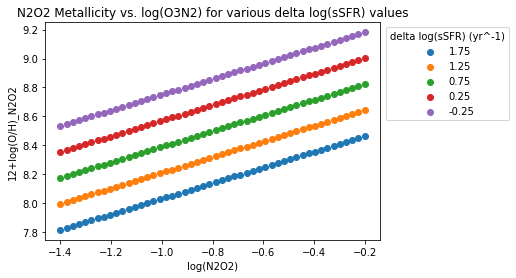

In [18]:
# # Reproducing Figure 6 from Brown et al

# logN2O2 = np.linspace(-1.4,-0.2)

# results1 = findMetallicities_Brown(objmaps,massMap,logN2O2=logN2O2,delt=1.75)
# results2 = findMetallicities_Brown(objmaps,massMap,logN2O2=logN2O2,delt=1.25)
# results3 = findMetallicities_Brown(objmaps,massMap,logN2O2=logN2O2,delt=0.75)
# results4 = findMetallicities_Brown(objmaps,massMap,logN2O2=logN2O2,delt=0.25)
# results5 = findMetallicities_Brown(objmaps,massMap,logN2O2=logN2O2,delt=-0.25)

# # plt.figure(figsize=(6,6))

# plt.scatter(results1['logN2O2flux'],results1['N2O2']['metallicity'])
# plt.scatter(results2['logN2O2flux'],results2['N2O2']['metallicity'])
# plt.scatter(results3['logN2O2flux'],results3['N2O2']['metallicity'])
# plt.scatter(results4['logN2O2flux'],results4['N2O2']['metallicity'])
# plt.scatter(results5['logN2O2flux'],results5['N2O2']['metallicity'])
# plt.legend([1.75,1.25,0.75,0.25,-0.25],title='delta log(sSFR) (yr^-1)',loc='upper right',bbox_to_anchor=(1.4,1))
# plt.title('N2O2 Metallicity vs. log(O3N2) for various delta log(sSFR) values')
# plt.xlabel('log(N2O2)')
# plt.ylabel('12+log(O/H)_N2O2')
# # plt.xlim([-1.8,-0.4])
# # plt.ylim([7.7,9.3])

# # plt.savefig('PosterMaps/BrownFig6Recreation')